In [1]:
import os
import yaml
import pandas as pd
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display 
pd.options.display.max_columns = None
%matplotlib inline

In [2]:
role = 'johnson_county_ddj_write'

In [3]:
def connect(poolclass=sqlalchemy.pool.QueuePool):
    with open(os.path.join(os.path.join('../..', 'config'), 'db_default_profile.yaml')) as fd:
        config = yaml.load(fd)
        dburl = sqlalchemy.engine.url.URL(
            "postgres",
            host=config["host"],
            username=config["user"],
            database=config["db"],
            password=config["pass"],
            port=config["port"],
        )
        return sqlalchemy.create_engine(dburl, poolclass=poolclass)

conn = connect()

/home/krodolfa/.pyenv/versions/joco-venv-3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
def execute_query(query, columns=None, verbose=False):
    if verbose:
        print("Query is ", query)
    query = """SET ROLE {}; {};""".format(role, query)
    return pd.read_sql(query, conn)

In [5]:
df = execute_query('SELECT * FROM kit_bias_testbed.model_adjustment_results')

In [7]:
df.head()

,model_id,metric,parameter,base_value,base_max_recall_ratio,adj_value,adj_max_recall_ratio,value_diff,recall_ratio_diff
0,204343,precision@,500_abs,0.572,1.510612,0.556,1.028282,-0.016,-0.482330
1,204380,precision@,500_abs,0.396,1.576314,0.414,1.049624,0.018,-0.526690
2,204351,precision@,500_abs,0.578,1.616927,0.562,1.007530,-0.016,-0.609397
3,204353,precision@,500_abs,0.566,1.692886,0.576,1.025773,0.010,-0.667113
4,204329,precision@,500_abs,0.564,1.692886,0.574,1.019844,0.010,-0.673042


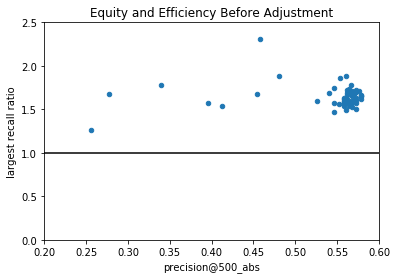

In [25]:
ax = df.plot('base_value', 'base_max_recall_ratio', kind='scatter')
ax.set_xlim((0.2, 0.6))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Before Adjustment')
plt.plot((0,1),(1,1),'k-')
plt.show()

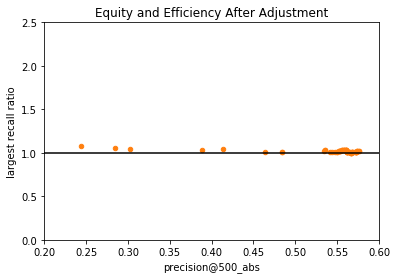

In [48]:
ax = df.plot('adj_value', 'adj_max_recall_ratio', kind='scatter', color='C1')
ax.set_xlim((0.2, 0.6))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency After Adjustment')
plt.plot((0,1),(1,1),'k-')
plt.show()

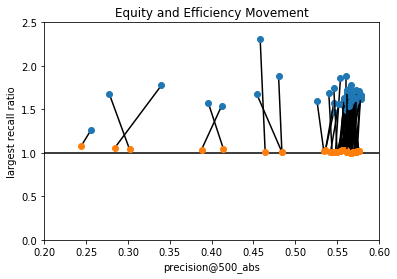

In [49]:
arr = df[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.2, 0.6))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Movement')

plt.show()

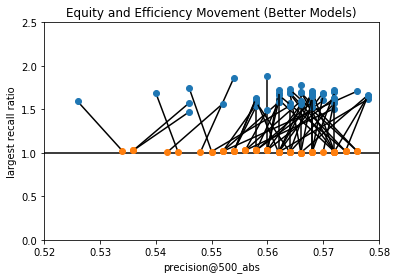

In [51]:
arr = df[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.52, 0.58))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Movement (Better Models)')

plt.show()

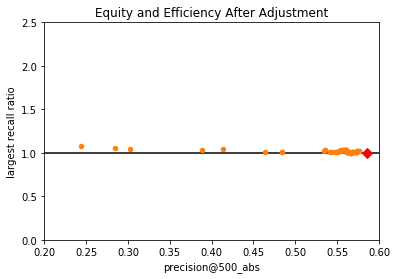

In [40]:
ax = df.plot('adj_value', 'adj_max_recall_ratio', kind='scatter', color='C1')
ax.set_xlim((0.2, 0.6))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency After Adjustment')
plt.plot(0.586, 1.00159438775510204083866368, marker='D', color='red', markersize=7)
plt.plot((0,1),(1,1),'k-', zorder=0)
plt.show()

## VERSION 2: RECALL ADJUSTMENTS IN THE PAST

More in line with actual application -- do the recall adjustments one full test set back (so, here, roll back 1 year) to find the relative group numbers, then evaluate on the subsequent test set...

In [53]:
df2 = execute_query('SELECT * FROM kit_bias_testbed.model_adjustment_results_v2')

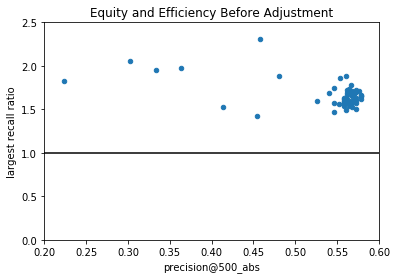

In [54]:
# this should be basically the same as above (up to randomness in tie breaking) since it's unadjusted
ax = df2.plot('base_value', 'base_max_recall_ratio', kind='scatter')
ax.set_xlim((0.2, 0.6))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Before Adjustment')
plt.plot((0,1),(1,1),'k-')
plt.show()

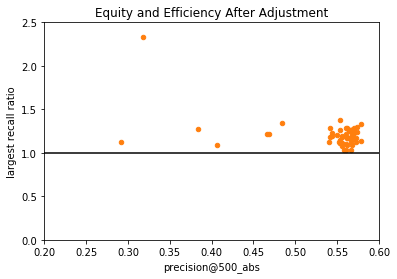

In [55]:
# but this should be quite different...
ax = df2.plot('adj_value', 'adj_max_recall_ratio', kind='scatter', color='C1')
ax.set_xlim((0.2, 0.6))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency After Adjustment')
plt.plot((0,1),(1,1),'k-')
plt.show()

So, things certainly improve, but nearly as nicely onto the 1.0 (equal recall) line...

Also important to keep in mind here is that there isn't a fixed base group, so the groups comprising the ratio in the blue dots might differ from those composing the ratio in the orange dots and ratios below 1.0 are impossible (we consider all combinations of numerator and denominator). So, the persisting inequality could reflect either not making sufficiently large adjustments OR over-correcting (or some combination of the two across models). Probably also worth looking how this moves with a fixed reference group and the largest ratio relative to that group...

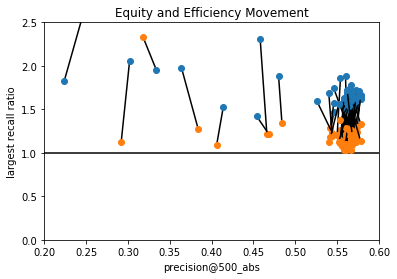

In [61]:
arr = df2[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.2, 0.6))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Movement')

plt.show()

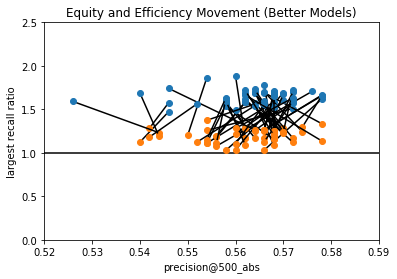

In [57]:
arr = df2[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.52, 0.59))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency Movement (Better Models)')

plt.show()

In [58]:
execute_query("""
SELECT AVG(base_value), AVG(base_max_recall_ratio), AVG(value_diff), AVG(recall_ratio_diff)
FROM kit_bias_testbed.model_adjustment_results_v2
WHERE base_value >= 0.52
;
""")

,avg,avg,avg,avg
0,0.5635,1.638623,-0.00125,-0.443215


on average, lose just 0.1pp in precision while recall ratio decreases by 0.44 (from baseline of 1.64)

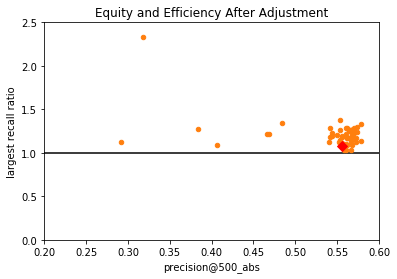

In [59]:
# let's try adding the composite with calculation in the previous test set
ax = df2.plot('adj_value', 'adj_max_recall_ratio', kind='scatter', color='C1')
ax.set_xlim((0.2, 0.6))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio')
ax.set_title('Equity and Efficiency After Adjustment')
plt.plot(0.556, 1.08261124728138916696222116, marker='D', color='red', markersize=7)
plt.plot((0,1),(1,1),'k-', zorder=0)
plt.show()

### Recall ratios with white as a reference group (so white-to-other ratio)

In [72]:
df2 = execute_query('SELECT * FROM kit_bias_testbed.model_adjustment_results_v2')

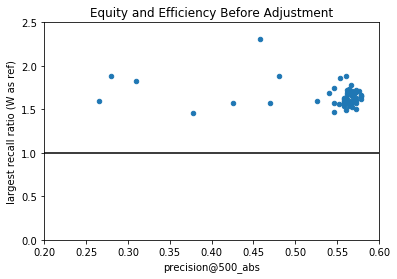

In [65]:
ax = df2.plot('base_value', 'base_max_recall_vs_white', kind='scatter')
ax.set_xlim((0.2, 0.6))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio (W as ref)')
ax.set_title('Equity and Efficiency Before Adjustment')
plt.plot((0,1),(1,1),'k-')
plt.show()

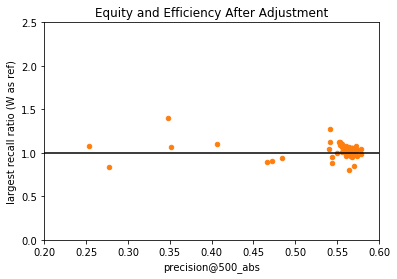

In [66]:
ax = df2.plot('adj_value', 'adj_max_recall_vs_white', kind='scatter', color='C1')
ax.set_xlim((0.2, 0.6))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio (W as ref)')
ax.set_title('Equity and Efficiency After Adjustment')
plt.plot((0,1),(1,1),'k-')
plt.show()

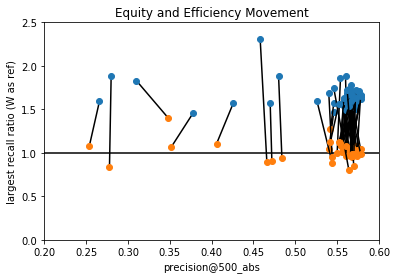

In [68]:
arr = df2[['base_value', 'base_max_recall_vs_white', 'adj_value', 'adj_max_recall_vs_white']].values
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.2, 0.6))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio (W as ref)')
ax.set_title('Equity and Efficiency Movement')

plt.show()

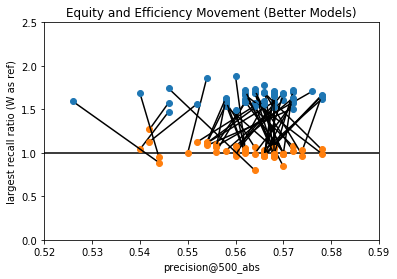

In [67]:
arr = df2[['base_value', 'base_max_recall_vs_white', 'adj_value', 'adj_max_recall_vs_white']].values
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.52, 0.59))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio (W as ref)')
ax.set_title('Equity and Efficiency Movement (Better Models)')

plt.show()

### Specific Group Ratios

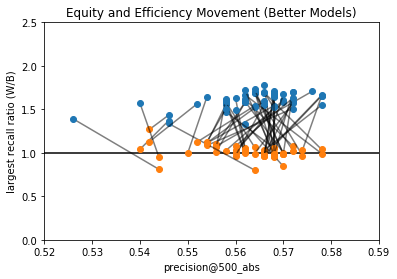

In [78]:
arr = df2[['base_value', 'base_recall_w_to_b', 'adj_value', 'adj_recall_w_to_b']].values
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-', alpha=0.5)
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.52, 0.59))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio (W/B)')
ax.set_title('Equity and Efficiency Movement (Better Models)')

plt.show()

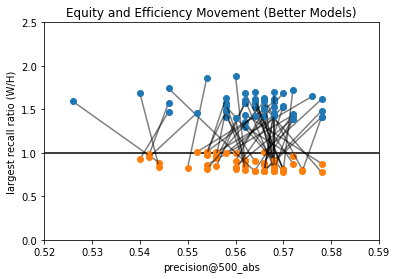

In [79]:
arr = df2[['base_value', 'base_recall_w_to_h', 'adj_value', 'adj_recall_w_to_h']].values
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-', alpha=0.5)
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.52, 0.59))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio (W/H)')
ax.set_title('Equity and Efficiency Movement (Better Models)')

plt.show()

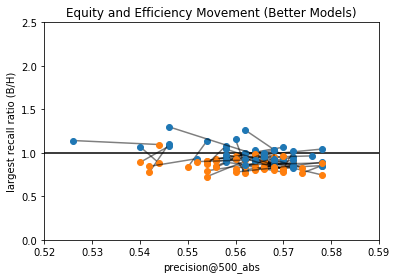

In [80]:
arr = df2[['base_value', 'base_recall_b_to_h', 'adj_value', 'adj_recall_b_to_h']].values
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-', alpha=0.5)
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.52, 0.59))
ax.set_ylim((0,2.5))
ax.set_xlabel('precision@500_abs')
ax.set_ylabel('largest recall ratio (B/H)')
ax.set_title('Equity and Efficiency Movement (Better Models)')

plt.show()

Looking at the specific ratios, it seems the models were initially over-selecting white individuals (relative to both black and hispanic individuals). In this particular case, the adjustments did a good job of removing disparities between white and black individuals and actually overshot somewhat for hispanics relative to whites. Recall ratios between black and hispanic individuals were actually relatively balanced and the movement there seems to be primarily dominated by noise, though the newer models on average seem to have moved towards slightly higer recall among hispanics.